In [69]:
import os
import os.path as osp
import sys
import numpy as np

In [25]:
abspath = os.path.abspath('.')
root_path = os.path.split(abspath)[0]

In [18]:
help(sys.path.insert)

Help on built-in function insert:

insert(...) method of builtins.list instance
    L.insert(index, object) -- insert object before index



In [21]:
sys.path.insert(0, osp.join(root_path, 'cocoapi' ,'PythonAPI'))

In [70]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

class Dataset(object):
    
    dataset_name = 'COCO'
    num_kps = 17
    kps_names = ['nose', 'l_eye', 'r_eye', 'l_ear', 'r_ear', 'l_shoulder',
    'r_shoulder', 'l_elbow', 'r_elbow', 'l_wrist', 'r_wrist',
    'l_hip', 'r_hip', 'l_knee', 'r_knee', 'l_ankle', 'r_ankle']
    kps_symmetry = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
    kps_lines = [(1, 2), (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (5, 7), (7, 9), (12, 14), (14, 16), (11, 13), (13, 15), (5, 6), (11, 12)]

    human_det_path = osp.join(root_path, 'datasets', dataset_name, 'dets', 'human_detection.json') # human detection result
    img_path = osp.join(root_path, 'datasets', dataset_name, 'images')
    val_annot_path = osp.join(root_path, 'datasets', dataset_name, 'annotations', 'person_keypoints_train2017.json')
    train_annot_path = osp.join(root_path, 'datasets', dataset_name, 'annotations', 'person_keypoints_val2017.json')
    test_annot_path = osp.join(root_path, 'datasets', dataset_name, 'annotations', 'image_info_test-dev2017.json')

    def load_train_data(self, score=False):
        coco = COCO(self.train_annot_path)
        train_data = []
        for aid in coco.anns.keys():
            ann = coco.anns[aid]
            imgname = 'train2017/' + coco.imgs[ann['image_id']]['file_name']
            joints = ann['keypoints']
 
            if (ann['image_id'] not in coco.imgs) or ann['iscrowd'] or (np.sum(joints[2::3]) == 0) or (ann['num_keypoints'] == 0):
                continue
           
            # sanitize bboxes
            x, y, w, h = ann['bbox']
            img = coco.loadImgs(ann['image_id'])[0]
            width, height = img['width'], img['height']
            x1 = np.max((0, x))
            y1 = np.max((0, y))
            x2 = np.min((width - 1, x1 + np.max((0, w - 1))))
            y2 = np.min((height - 1, y1 + np.max((0, h - 1))))
            if ann['area'] > 0 and x2 >= x1 and y2 >= y1:
                bbox = [x1, y1, x2-x1, y2-y1]
            else:
                continue
            
            if score:
                data = dict(image_id = ann['image_id'], imgpath = imgname, bbox=bbox, joints=joints, score=1)
            else:
                data = dict(image_id = ann['image_id'], imgpath = imgname, bbox=bbox, joints=joints)

            train_data.append(data)

        return train_data
    
    def load_val_data_with_annot(self):
        coco = COCO(self.val_annot_path)
        val_data = []
        for aid in coco.anns.keys():
            ann = coco.anns[aid]
            if ann['image_id'] not in coco.imgs:
                continue
            imgname = 'val2017/' + coco.imgs[ann['image_id']]['file_name']
            bbox = ann['bbox']
            joints = ann['keypoints']
            data = dict(image_id = ann['image_id'], imgpath = imgname, bbox=bbox, joints=joints, score=1)
            val_data.append(data)

        return val_data

    def load_annot(self, db_set):
        if db_set == 'train':
            coco = COCO(self.train_annot_path)
        elif db_set == 'val':
            coco = COCO(self.val_annot_path)
        elif db_set == 'test':
            coco = COCO(self.test_annot_path)
        else:
            print('Unknown db_set')
            assert 0

        return coco

    def load_imgid(self, annot):
        return annot.imgs

    def imgid_to_imgname(self, annot, imgid, db_set):
        imgs = annot.loadImgs(imgid)
        imgname = [db_set + '2017/' + i['file_name'] for i in imgs]
        return imgname

    def evaluation(self, result, gt, result_dir, db_set):
        result_path = osp.join(result_dir, 'result.json')
        with open(result_path, 'w') as f:
            json.dump(result, f)

        result = gt.loadRes(result_path)
        cocoEval = COCOeval(gt, result, iouType='keypoints')

        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

        result_path = osp.join(result_dir, 'result.pkl')
        with open(result_path, 'wb') as f:
            pickle.dump(cocoEval, f, 2)
            print("Saved result file to " + result_path)
    
    def vis_keypoints(self, img, kps, kp_thresh=0.4, alpha=1):

        # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
        cmap = plt.get_cmap('rainbow')
        colors = [cmap(i) for i in np.linspace(0, 1, len(self.kps_lines) + 2)]
        colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

        # Perform the drawing on a copy of the image, to allow for blending.
        kp_mask = np.copy(img)

        # Draw mid shoulder / mid hip first for better visualization.
        mid_shoulder = (
            kps[:2, 5] +
            kps[:2, 6]) / 2.0
        sc_mid_shoulder = np.minimum(
            kps[2, 5],
            kps[2, 6])
        mid_hip = (
            kps[:2, 11] +
            kps[:2, 12]) / 2.0
        sc_mid_hip = np.minimum(
            kps[2, 11],
            kps[2, 12])
        nose_idx = 0
        if sc_mid_shoulder > kp_thresh and kps[2, nose_idx] > kp_thresh:
            cv2.line(
                kp_mask, tuple(mid_shoulder.astype(np.int32)), tuple(kps[:2, nose_idx].astype(np.int32)),
                color=colors[len(self.kps_lines)], thickness=2, lineType=cv2.LINE_AA)
        if sc_mid_shoulder > kp_thresh and sc_mid_hip > kp_thresh:
            cv2.line(
                kp_mask, tuple(mid_shoulder.astype(np.int32)), tuple(mid_hip.astype(np.int32)),
                color=colors[len(self.kps_lines) + 1], thickness=2, lineType=cv2.LINE_AA)

        # Draw the keypoints.
        for l in range(len(self.kps_lines)):
            i1 = self.kps_lines[l][0]
            i2 = self.kps_lines[l][1]
            p1 = kps[0, i1].astype(np.int32), kps[1, i1].astype(np.int32)
            p2 = kps[0, i2].astype(np.int32), kps[1, i2].astype(np.int32)
            if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
                cv2.line(
                    kp_mask, p1, p2,
                    color=colors[l], thickness=2, lineType=cv2.LINE_AA)
            if kps[2, i1] > kp_thresh:
                cv2.circle(
                    kp_mask, p1,
                    radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
            if kps[2, i2] > kp_thresh:
                cv2.circle(
                    kp_mask, p2,
                    radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

        # Blend the keypoints.
        return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

In [71]:
dbcfg = Dataset()

In [73]:
train_data = dbcfg.load_train_data()

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [74]:
dir(train_data)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [75]:
train_data[0]

{'image_id': 425226,
 'imgpath': 'train2017/000000425226.jpg',
 'bbox': [73.35, 206.02, 299.5799999999999, 371.5],
 'joints': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  142,
  309,
  1,
  177,
  320,
  2,
  191,
  398,
  2,
  237,
  317,
  2,
  233,
  426,
  2,
  306,
  233,
  2,
  92,
  452,
  2,
  123,
  468,
  2,
  0,
  0,
  0,
  251,
  469,
  2,
  0,
  0,
  0,
  162,
  551,
  2]}

In [44]:
osp.join(root_path, 'datasets', 'COCO', 'val2017/000000440475.jpg')

'/home/kerry/prj/lab4/datasets/COCO/val2017/000000440475.jpg'

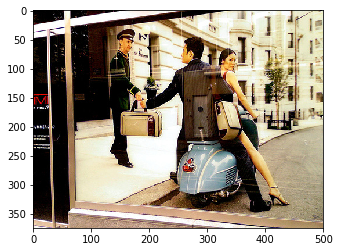

In [51]:
from matplotlib import pyplot as plt
x = plt.imread(osp.join(root_path, 'datasets', 'COCO', 'val2017/000000292456.jpg'))
plt.imshow(x)

In [52]:
for i in val_data:
    if i['imgpath'] == 'val2017/000000292456.jpg':
        print('here!!')

here!!
here!!
here!!


In [58]:
val_data.load_

{'image_id': 425226,
 'imgpath': 'val2017/000000425226.jpg',
 'bbox': [73.35, 206.02, 300.58, 372.5],
 'joints': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  142,
  309,
  1,
  177,
  320,
  2,
  191,
  398,
  2,
  237,
  317,
  2,
  233,
  426,
  2,
  306,
  233,
  2,
  92,
  452,
  2,
  123,
  468,
  2,
  0,
  0,
  0,
  251,
  469,
  2,
  0,
  0,
  0,
  162,
  551,
  2],
 'score': 1}

In [54]:
anno = dbcfg.load_annot('val')

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [55]:
print(type(anno))

<class 'pycocotools.coco.COCO'>


In [57]:
dir(anno)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'annToMask',
 'annToRLE',
 'anns',
 'catToImgs',
 'cats',
 'createIndex',
 'dataset',
 'download',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'imgToAnns',
 'imgs',
 'info',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'loadNumpyAnnotations',
 'loadRes',
 'showAnns']

In [65]:
anno.imgToAnns([425226])

TypeError: 'collections.defaultdict' object is not callable

In [83]:
train_data[0]

{'image_id': 425226,
 'imgpath': 'train2017/000000425226.jpg',
 'bbox': [73.35, 206.02, 299.5799999999999, 371.5],
 'joints': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  142,
  309,
  1,
  177,
  320,
  2,
  191,
  398,
  2,
  237,
  317,
  2,
  233,
  426,
  2,
  306,
  233,
  2,
  92,
  452,
  2,
  123,
  468,
  2,
  0,
  0,
  0,
  251,
  469,
  2,
  0,
  0,
  0,
  162,
  551,
  2]}

In [92]:
dbcfg.kps_symmetry

[(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

In [97]:
def generate_batch(d, stage='train'):
    
    img = cv2.imread(os.path.join(root_path, 'datasets', 'images', d['imgpath']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    if img is None:
        print('cannot read ' + os.path.join(root_path, 'datasets', 'images', d['imgpath'])
    
    print('s')
    bbox = np.array(d['bbox']).astype(np.float32)
    
    x, y, w, h = bbox
    input_shape = (256, 192)
    aspect_ratio = input_shape[1]/input_shape[0]
    center = np.array([x + w * 0.5, y + h * 0.5])
    if w > aspect_ratio * h:
        h = w / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array([w,h]) * 1.25
    rotation = 0

    if stage == 'train':

        joints = np.array(d['joints']).reshape(17, 3).astype(np.float32)
        
        # data augmentation
        scale = scale * np.clip(np.random.randn()*0.3 + 1, 1-0.3, 1+0.3)
        rotation = np.clip(np.random.randn()*40, -40*2, 40*2)\
                if random.random() <= 0.6 else 0
        if random.random() <= 0.5:
            img = img[:, ::-1, :]
            center[0] = img.shape[1] - 1 - center[0]
            joints[:,0] = img.shape[1] - 1 - joints[:,0]
            for (q, w) in dbcfg.kps_symmetry:
                joints_q, joints_w = joints[q,:].copy(), joints[w,:].copy()
                joints[w,:], joints[q,:] = joints_q, joints_w

        trans = get_affine_transform(center, scale, rotation, (input_shape[1], input_shape[0]))
        cropped_img = cv2.warpAffine(img, trans, (input_shape[1], input_shape[0]), flags=cv2.INTER_LINEAR)
        #cropped_img = cropped_img[:,:, ::-1]
        #cropped_img = cfg.normalize_input(cropped_img)
        
        for i in range(dbcfg.num_kps):
            if joints[i,2] > 0:
                joints[i,:2] = affine_transform(joints[i,:2], trans)
                joints[i,2] *= ((joints[i,0] >= 0) & (joints[i,0] < input_shape[1]) & (joints[i,1] >= 0) & (joints[i,1] < input_shape[0]))
        target_coord = joints[:,:2]
        target_valid = joints[:,2]
        
        # for debug
        vis = False
        if vis:
            filename = str(random.randrange(1,500))
            tmpimg = cropped_img.astype(np.float32).copy()
            tmpimg = cfg.denormalize_input(tmpimg)
            tmpimg = tmpimg.astype(np.uint8).copy()
            tmpkps = np.zeros((3,cfg.num_kps))
            tmpkps[:2,:] = target_coord.transpose(1,0)
            tmpkps[2,:] = target_valid
            tmpimg = cfg.vis_keypoints(tmpimg, tmpkps)
            cv2.imwrite(osp.join(cfg.vis_dir, filename + '_gt.jpg'), tmpimg)
        
        return [cropped_img,
                target_coord, 
                (target_valid > 0)]

    else:
        trans = get_affine_transform(center, scale, rotation, (input_shape[1], input_shape[0]))
        cropped_img = cv2.warpAffine(img, trans, (input_shape[1], input_shape[0]), flags=cv2.INTER_LINEAR)
        #cropped_img = cropped_img[:,:, ::-1]
        #cropped_img = cfg.normalize_input(cropped_img)

        crop_info = np.asarray([center[0]-scale[0]*0.5, center[1]-scale[1]*0.5, center[0]+scale[0]*0.5, center[1]+scale[1]*0.5])

        return [cropped_img, crop_info]

SyntaxError: invalid syntax (<ipython-input-97-60d59acb06ff>, line 7)

In [95]:
import cv2
generate_batch(train_data[0])

NameError: name 'cfg' is not defined